In [1]:
from utils import *

In [2]:
def findLines(img):
    # Adapted from https://docs.opencv.org/4.4.0/dd/dd7/tutorial_morph_lines_detection.html

    # Get image height and width to dynamically change
    # horizontal and vertical kernel sizes
    height, width = img.shape

    # Erode image to thicken lines
    eroded = cv.erode(img, np.ones((3, 3)))

    kernel_length = 3 / 100

    # To find horizontal lines, run a horizontal kernel (e.g. [1 1 1 1])
    # Dilation finds lines, but shrinks their lengths, so
    # follow with Erosion to restore original lines' size
    horizontal_kernel = np.ones((1, int(width * kernel_length)))
    horizontal = cv.morphologyEx(eroded, cv.MORPH_CLOSE, horizontal_kernel)
    
    # To find vertical lines, run a vertical kernel
    vertical_kernel = np.ones((int(height * kernel_length), 1))
    vertical = cv.morphologyEx(eroded, cv.MORPH_CLOSE, vertical_kernel)

    lines = cv.bitwise_and(vertical, horizontal)
    lines = cv.erode(lines, np.ones((3, 3)), iterations=3)

    return lines

In [3]:

def findRows(cell_contours):
    rows = {}

    for cnt in cell_contours:
        # Approximate contour to a rectangle, get x, y, width and height
        x, y, width, height = cv.boundingRect(cnt)

        # Ignore cell contours with width or height < 15px
        if width < 15 or height < 15:
            continue

        # Contour could have a strange shape, so replace original contour
        # with the approximated bounding rectange shape
        cnt = np.array([
            (x, y), # Top left
            (x + width, y), # Top right
            (x + width, y + height), # Bottom right
            (x, y + height) # Bottom left
        ]).reshape((4, 2))

        # Keep track of whether the contour has been assigned to a row
        added = False

        # Iterate over existing rows where:
        # row = y-coordinate of the row
        for row in rows.keys():
            # Add this cell to the row that is on the same line (i.e. y-axis ± 50px)
            # as this cell's contour
            if (row - 50) <= y <= (row + 50):
                rows[row].append(cnt)
                added = True
                break

        # If the row wasn't added, create a new row with this cell's y-coordinate
        # as the row
        if not added:
            rows[y] = [cnt]

    # Sort rows top to bottom.
    rows = dict(sorted(rows.items()))

    # Sort cells left to right
    for key, value in rows.items():
        rows[key] = sorted(value, key=lambda cnt: cv.boundingRect(cnt)[0])
    
    return rows

In [4]:
def reconstructTable(rows, warped = None, ocrFunction = None):
    # Reconstruct the table following a top-to-bottom approach. Iterate over each row
    # and check for the number of cells. If there are more cells than the previous row,
    # this will indicate columns have been split, and the new row is treated as a new 
    # heading in the table.
    # Otherwise, if the same number of cells appear, this means the row contains new
    # values for the previous column, so add the cell content to the existing column.

    # EXAMPLE TABLE:
    # +-------+-------+
    # |   A   |   B   |
    # +---+---+---+---+
    # | C | D | E | F |
    # +---+---+---+---+
    # | 1 | 2 | 3 | 4 |
    # +---+---+---+---+

    # Store table as a disctionary, where:
    #   key = column name
    #   value = list of cell values
    # In the example above, table will look like the following: 
    #
    # table = {
    #   A: {
    #       C: [1],
    #       D: [2],
    #   },
    #   B: {
    #       E: [3],
    #       F: [4]
    #   }
    # }
    table = {}

    # Columns is a reference to the values of the heading names.
    # For example, in the above example:
    # after the first iteration:    columns = [[], []]
    # after the second iteration:   columns = [[], [], [], []]
    # after the third iteration:    columns = [[1], [2], [3], [4]]
    columns = None
    columns_sizes = [] # Keep track of column sizes

    # Keep track of cell number for use in case OCR fails
    cell_number = 0

    for cells in rows.values():
        cell_sizes = [] # Keep track of cell sizes

        # Extract cell text (will be replaced with OCR)
        cell_contents = []
        for cnt in cells:
            # Extract cell region from image
            x1, y1 = cnt[0]
            x2, y2 = cnt[2]
            cell_sizes.append(x2 - x1) # Add cell width to the list of cell sizes

            # Perform OCR if image and ocrFunction are passed in
            if warped is not None and callable(ocrFunction):
                cell = warped[y1:y2, x1:x2]
                text = ocrFunction(cell)
            # Otherwise return cell number
            else:
                text = str(cell_number)

            if text == "":
                text = "(failed) cell #" + str(cell_number)
            cell_contents.append(text)
            cell_number += 1
        
        if columns is None:
            # FIRST ITERATION
            # Add first row to the table
            for cell in cell_contents:
                table[cell] = []
            columns = list(table.values())
            columns_sizes = cell_sizes

        elif len(cell_contents) > len(columns):
            # DIFFERENT NUMBER OF CELLS
            # Columns have been split, add this row as new headings

            # Replace the previous columns to be new dictionaries.
            # At this line, columns contains the lists of the last headings. Because new
            # headings have been found, the last headings are converted from lists to
            # dictionaries.
            columns = leafListToDict(table)

            # Keep track of the previous headings
            previous_headings = list(columns)

            # Create new columns for each of the new headings
            columns = [[] for _ in cell_contents]

            # Split the new headings into lists of equal size.
            # For instance, in the example table above they are split in groups of 2:
            #   - [C, D] are children of A
            #   - [E, F] are children of B
            # This is done by comparing the current column size (+1%) to the cell sizes.
            # When the column size is exceeded, this will indicate a new column has started.
            current_column_index = 0 # Keep track of current column
            current_width = 0 # Aggregate all cell sizes to check against column size

            for i, heading in enumerate(cell_contents):
                current_width += cell_sizes[i] # Add current cell width to current column

                # If cell doesn't fit in the current column, move to the next one
                if current_width > columns_sizes[current_column_index] * 1.01:
                    current_column_index += 1
                    current_width = cell_sizes[i]

                # Add this new heading as child of previous heading
                previous_headings[current_column_index][heading] = columns[i]

            # Reset columns sizes
            columns_sizes = cell_sizes

        elif len(cell_contents) == len(columns):
            # SAME NUMBER OF CELLS
            # add all cells one by one to each column
            for i in range(len(cells)):
                columns[i].append(cell_contents[i])
        
        elif len(cell_contents) < len(columns):
            # LESS CELLS THAN PREVIOUS ROW
            # This might happen if a table is of the following structure:
            # +-------+-------+
            # |   A   |   B   |
            # +---+---+---+---+
            # | C | D | E | F |
            # +---+---+---+---+
            # |       G       |
            # +---+---+---+---+
            # In this example, the third row has 4 cells, and it's followed by a row
            # of 1 cell. Unfortunately I couldn't find a nice way to store such rows
            # in a JSON file, so the table extraction is stopped at this stage.
            break
    return table

In [5]:
def Table_Extraction(path,ocrFunction = None):
    # Dictonary to store data to be returned
    ret = {}
    # Read Image
    Gray_Scale_img=Read_GrayScale_Image(path)
    # Gray_Scale_img=rgb2gray(Original_img)

    # Show_Images([Original_img],['Original'])
    show_images([Gray_Scale_img],['GrayScale'])
    
    # Step 1 Enhance lines of the image
    #1.Guassian to blur image 
    kernel_size=max(int(Gray_Scale_img.shape[0] * 0.005), int(Gray_Scale_img.shape[1] * 0.005))
    # Kernel must have odd values because of GaussianBlur
    if kernel_size % 2 == 0:
        kernel_size += 1
    kernel=(kernel_size,kernel_size) #filter size
    Gaussian_Img=cv.GaussianBlur(Gray_Scale_img,kernel,1)
    print(np.shape(Gaussian_Img))
    
    #2.Adpative Thresholding
    # If we tried to use Normal Thresholding =>Global Thresholding Regions Black so use like local thershold for every region depending on its neigh
    Thresholded_Img = cv.adaptiveThreshold(Gaussian_Img, 255,cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY_INV, 21, 10)
    #3.La Placian
    laplacian = cv.Laplacian(Thresholded_Img, cv.CV_64F)
    # Convert data type from 64f to unsigned 8-bit integer
    laplacian = np.uint8(np.absolute(laplacian))
#     show_images([Gray_Scale_img,Gaussian_Img],['Gray Scale Imge','Guassian Sigma=1'])
#     show_images([Thresholded_Img,laplacian],['Thersholded Img','La Placian'])
    
    # Extract Table Region
    #Table takes most of the Region so Extract table by finding largest countor with 4 sides

    #1.Find Largest rectangle in the image
    # FIND CONTOUR
    contours, _ = cv.findContours(laplacian, cv.RETR_CCOMP, cv.CHAIN_APPROX_SIMPLE)
    #Identifying Contour with largest 4 sides
    table_contour, table_contour_approx = findLargestQuadrilateralContour(contours)
    if table_contour[0] is None:
        raise ValueError("No table detected.")
    print(table_contour_approx)
    
    # Sort points in clocwise order, compute table width and height
    table_pts, table_width, table_height =processContour(table_contour_approx[0])\
    
    #2.
    # EXTRACT TABLE REGION
    # Start with a full black image
    mask = np.zeros(Gray_Scale_img.shape).astype(Gray_Scale_img.dtype)
    # Create a mask for the table region
    cv.fillPoly(mask, table_contour, (255, 255, 255))
    
    # Apply the mask to the thresholded image, filling the region
    # outside of the table with white
    table_img = cv.bitwise_and(Gray_Scale_img, mask)
    
    
    # WARP TABLE
    # Use warp to extract the table region from the processed image
    # by mapping table points to a new image of size table_width x table_height
    target_points = np.float32([[0, 0], [table_width, 0], [table_width, table_height], [0, table_height]])
    matrix = cv.getPerspectiveTransform(table_pts, target_points)
    # Apply warp to the image to extract the tbale region
    warped = cv.warpPerspective(table_img, matrix, (table_width, table_height))
    # Apply warp to mask
    warped_mask = cv.warpPerspective(mask, matrix, (table_width, table_height))
    # Resize warped and mask to have width 750px
    scale_factor = 1500 / table_width
    warped = cv.resize(warped, (0, 0), fx=scale_factor, fy=scale_factor)
    warped_mask = cv.resize(warped_mask, (0, 0), fx=scale_factor, fy=scale_factor)
    warped = cv.GaussianBlur(warped, (5, 5), 2)
    # Apply threshold
    warped = cv.adaptiveThreshold(warped, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY, 9, 2)
    
    
    # FIND HORIZONTAL & VERTICAL LINES
    lines_1 = findLines(warped)
    # Since the funciton above might get rid of the black area outside the table
    # region, apply mask again
    lines = cv.bitwise_and(lines_1, warped_mask)
    
    
      # EXTRACT CELLS
    # Get each cell's contour
    cell_contours, _ = cv.findContours(lines, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    
    # Sometimes the contour of the table is detected again, so filter large contours out
    warpedArea = warped.shape[0] * warped.shape[1] * 0.9

    def validContour(cnt):
        _, _, w, h = cv.boundingRect(cnt)
        return w * h < warpedArea

    cell_contours = [cnt for cnt in cell_contours if validContour(cnt)]
    
    
    # Group cells by row
    # findRows returns a Python dictonary with
    #   key = y value of the row
    #   value = array of cell contours in the row
    rows = findRows(cell_contours)

    # Compute number of rows and cells
    ret["rows"] = len(rows.values())
    ret["cells"] = sum([len(c) for c in rows.values()])
    
    
    # CREATE TABLE IMAGE WITHOUT LINES
    # This will help the OCR engine perform better.
    # Start with a full white image, add the cells as black rectangles and use the OR operation
    # to remove all the lines.
    text_mask = np.full(warped.shape, 255).astype(warped.dtype)
    # Merge (sum()) all the cell contours from rows (key-value dictonary)
    text_mask = cv.drawContours(text_mask, sum(rows.values(), []), -1, (0, 0, 0), -1)
    # Use close operation to dilate and erode image reducing overall noise
    text_only = cv.morphologyEx(warped, cv.MORPH_CLOSE, np.ones((3,3)))
    text_only = cv.bitwise_or(warped, text_mask)
    
    
    # RECONSTRUCT TABLE STRUCTURE
    try:
#         print("dfb")
        ret["table"] =reconstructTable(rows, text_only, ocrFunction)
#         ret[""] =155 print(1+2)
    except Exception:
        raise ValueError("Error while parsing table, try again with a clearer picture.")
    
    
    show_images([mask,table_img,warped],['Mask','Extracted_table'+path,'wrapped'])
    show_images([lines,lines_1,text_only])    
    
    print(ret)
    return table_img  
    


#### Table_Extraction('./grade sheet/1.jpg')
Table_Extraction('./grade sheet/2.jpg')
Table_Extraction('./grade sheet/3.jpg')
Table_Extraction('./grade sheet/4.jpg')
Table_Extraction('./grade sheet/5.jpg')
Table_Extraction('./grade sheet/6.jpg')
Table_Extraction('./grade sheet/7.jpg')
Table_Extraction('./grade sheet/8.jpg')
Table_Extraction('./grade sheet/9.jpg')
Table_Extraction('./grade sheet/10.jpg')

Table_Extraction('./grade sheet/11.jpg')
Table_Extraction('./grade sheet/12.jpg')
Table_Extraction('./grade sheet/13.jpg')
Table_Extraction('./grade sheet/14.jpg')
Table_Extraction('./grade sheet/15.jpg')

Table_Extraction('./grade sheet/gradesheet/1.jpg')
Table_Extraction('./grade sheet/gradesheet/2.jpg')
Table_Extraction('./grade sheet/gradesheet/3.jpg')
Table_Extraction('./grade sheet/gradesheet/4.jpg')
Table_Extraction('./grade sheet/gradesheet/5.jpg')
Table_Extraction('./grade sheet/gradesheet/6.jpg')
Table_Extraction('./grade sheet/gradesheet/7.jpg')
Table_Extraction('./grade sheet/gradesheet/8.jpg')




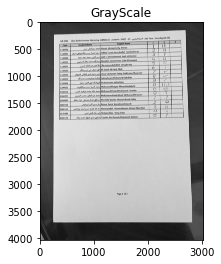

(4030, 3024)
[array([[[2690,  144]],

       [[ 249,  226]],

       [[ 239, 3711]],

       [[2814, 3707]]], dtype=int32)]


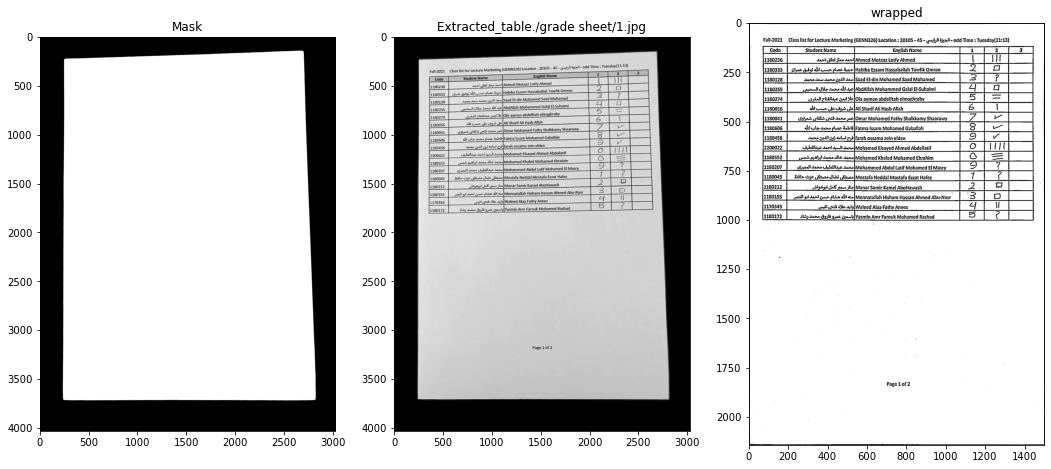

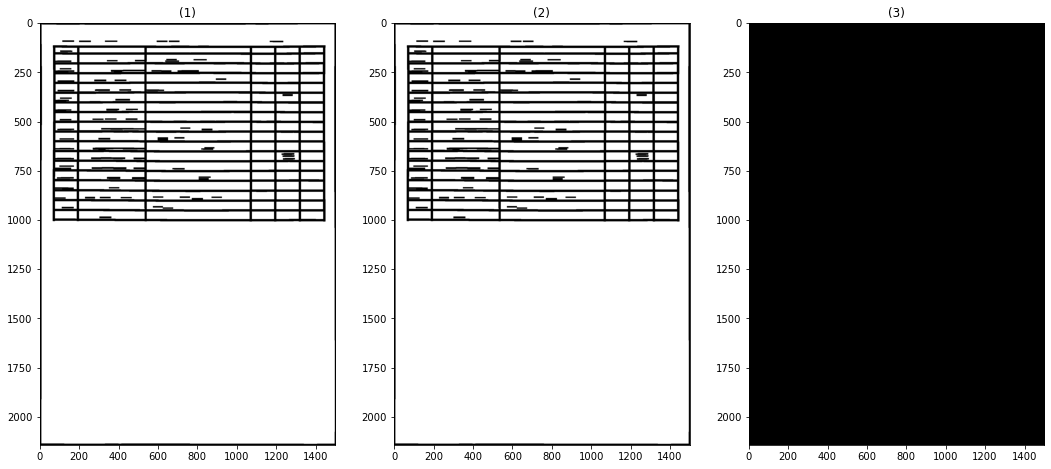

{'rows': 0, 'cells': 0, 'table': {}}


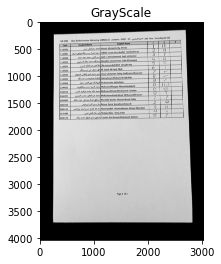

(4030, 3024)
[array([[[2690,  137]],

       [[ 243,  224]],

       [[ 241, 3715]],

       [[2819, 3712]]], dtype=int32)]


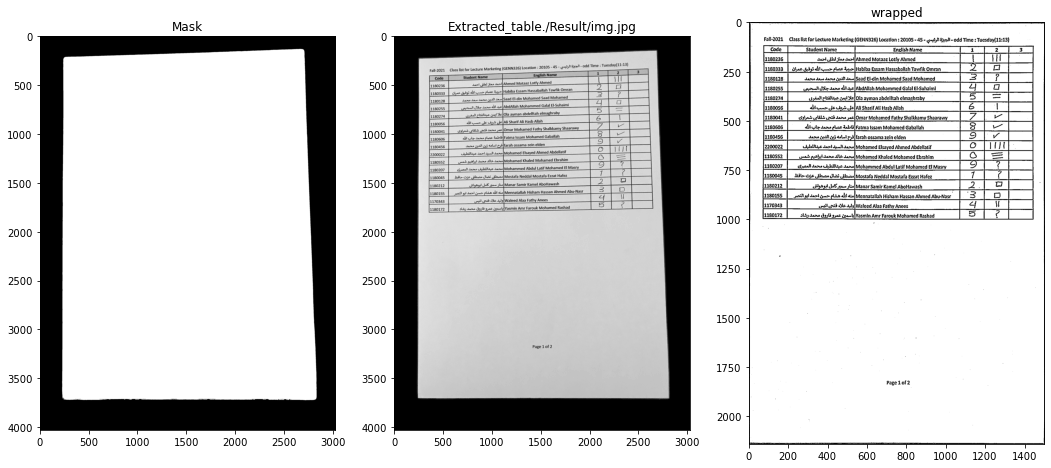

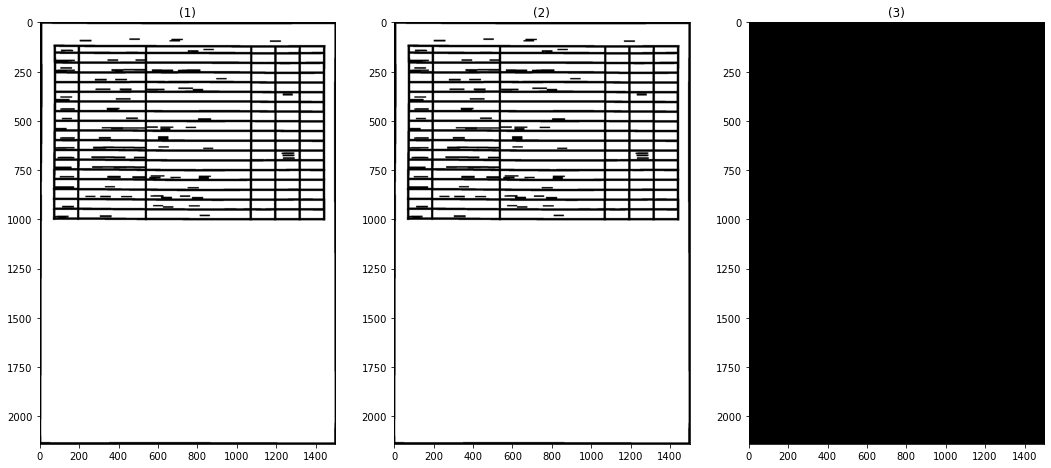

{'rows': 0, 'cells': 0, 'table': {}}


In [8]:

img1=Table_Extraction('./grade sheet/1.jpg')
cv.imwrite('./Result/img.jpg',img1)
img1=Table_Extraction('./Result/img.jpg')